
# Part 1 — EXTRACT: EDA for Layoff Risk

Use this notebook to understand the raw tech layoff dataset and prepare for modeling. It follows the course guide: inspect the public CSV, check data quality, create exploratory visuals, and align on the target used later in modeling.

What this notebook covers:
- Load `Data/tech_layoffs.csv` and surface schema, missingness, and duplicates.
- Light normalization for exploration (dates, layoffs counts, impact percentage).
- Visuals for trends and the binary target used downstream.
- Quick peek at the engineered features in `Data/cleaned_dataset.csv` that feed `Modeling.ipynb`.



## Setup
Detect the data directory (works whether you launch from repo root or `Notebooks/`), import common EDA libraries, and point to the raw/cleaned CSV files.


In [1]:

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

NOTEBOOK_DIR = Path().resolve()
DATA_DIR = None
for cand in [NOTEBOOK_DIR / "Data", NOTEBOOK_DIR.parent / "Data"]:
    if cand.exists():
        DATA_DIR = cand
        break
if DATA_DIR is None:
    raise FileNotFoundError("Could not find Data folder. Run the notebook from repo root or Notebooks/.")

RAW_PATH = DATA_DIR / "tech_layoffs.csv"
CLEAN_PATH = DATA_DIR / "cleaned_dataset.csv"
print("Data directory:", DATA_DIR)
RAW_PATH, CLEAN_PATH


Data directory: C:\Users\Daniel\Downloads\NEU_6105_Finall\Data


(WindowsPath('C:/Users/Daniel/Downloads/NEU_6105_Finall/Data/tech_layoffs.csv'),
 WindowsPath('C:/Users/Daniel/Downloads/NEU_6105_Finall/Data/cleaned_dataset.csv'))


## Inspect the raw Kaggle file (`tech_layoffs.csv`)
Check the shape and preview a few rows to confirm the expected columns before cleaning.


In [2]:

raw_df = pd.read_csv(RAW_PATH)
print(f"Raw shape: {raw_df.shape}")
raw_df.head()


Raw shape: (489, 9)


,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status,additional_notes
0,C2FO,20,2,12/9/2022,"Fintech, payments","Leawood, KS",Kansas City Business Journal,Private,NaN
1,VideoAmp,Unclear,2,9/19/2022,Advertising platforms,Los Angeles,Company memo,Private,NaN
2,Amperity,13,3,8/20/2022,"Saas, analytics",Seattle,Geekwire,Private,NaN
3,Addepar,20,3,1/18/2023,"fintech, data analytics","Mountain View, CA",Fortune,Private,NaN
4,Thirty Madison,24,3,5/13/2022,Health Care,New York,Axios,Private,"Per Axios, 22 of the employees laid off were f..."


In [3]:

# Basic schema + missingness
raw_df.info()
raw_missing = raw_df.isna().mean().sort_values(ascending=False)
raw_missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   company                        489 non-null    object
 1   total_layoffs                  489 non-null    object
 2   impacted_workforce_percentage  489 non-null    object
 3   reported_date                  489 non-null    object
 4   industry                       489 non-null    object
 5   headquarter_location           489 non-null    object
 6   sources                        489 non-null    object
 7   status                         489 non-null    object
 8   additional_notes               22 non-null     object
dtypes: object(9)
memory usage: 34.5+ KB


additional_notes                 0.95501
company                          0.00000
total_layoffs                    0.00000
reported_date                    0.00000
impacted_workforce_percentage    0.00000
industry                         0.00000
headquarter_location             0.00000
sources                          0.00000
status                           0.00000
dtype: float64


### Light normalization for exploration
Convert numeric/text fields so we can plot them (full cleaning happens in `Data/data_cleaning_script.ipynb`).


In [4]:

raw = raw_df.copy()
raw['reported_date'] = pd.to_datetime(raw['reported_date'], errors='coerce')
raw['layoffs'] = pd.to_numeric(raw['total_layoffs'].astype(str).str.replace(',', ''), errors='coerce')
raw['impact_pct'] = pd.to_numeric(raw['impacted_workforce_percentage'].astype(str).str.rstrip('%'), errors='coerce') / 100
for col in ['company', 'industry', 'headquarter_location', 'status']:
    raw[col] = raw[col].str.lower().str.strip()

raw = raw.dropna(subset=['reported_date'])
print(raw[['layoffs', 'impact_pct']].describe())
print("Null rows with missing layoffs or impact_pct:", len(raw) - len(raw.dropna(subset=['layoffs', 'impact_pct'])))
raw.head()


            layoffs  impact_pct
count    307.000000  356.000000
mean     450.019544    0.238764
std     1652.123678    0.248094
min        5.000000    0.010000
25%       44.000000    0.100000
50%       95.000000    0.150000
75%      200.000000    0.250000
max    18000.000000    1.000000
Null rows with missing layoffs or impact_pct: 249


,company,total_layoffs,impacted_workforce_percentage,reported_date,industry,headquarter_location,sources,status,additional_notes,layoffs,impact_pct
0,c2fo,20,2,2022-12-09,"fintech, payments","leawood, ks",Kansas City Business Journal,private,NaN,20.0,0.02
1,videoamp,Unclear,2,2022-09-19,advertising platforms,los angeles,Company memo,private,NaN,NaN,0.02
2,amperity,13,3,2022-08-20,"saas, analytics",seattle,Geekwire,private,NaN,13.0,0.03
3,addepar,20,3,2023-01-18,"fintech, data analytics","mountain view, ca",Fortune,private,NaN,20.0,0.03
4,thirty madison,24,3,2022-05-13,health care,new york,Axios,private,"Per Axios, 22 of the employees laid off were f...",24.0,0.03



### Visual: reported layoffs over time
Roll up layoffs by month to spot peaks in the dataset timeframe.


C:\Users\Daniel\AppData\Local\Temp\ipykernel_21964\1185439863.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = raw.groupby(pd.Grouper(key='reported_date', freq='M'))['layoffs'].sum().reset_index()


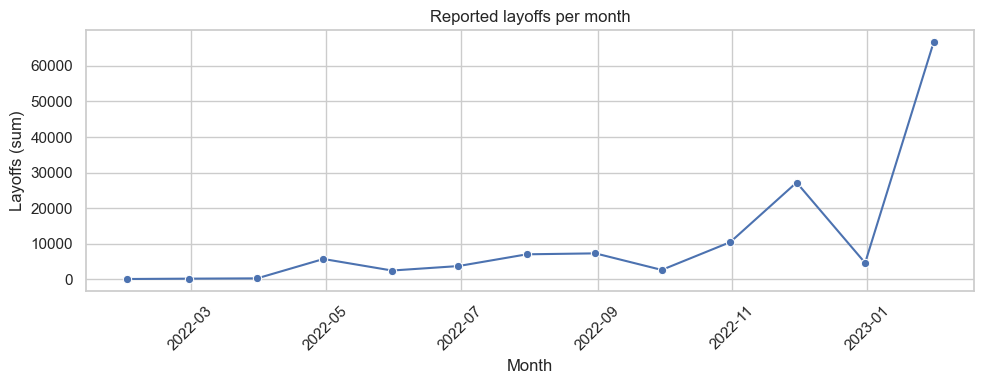

In [5]:

monthly = raw.groupby(pd.Grouper(key='reported_date', freq='M'))['layoffs'].sum().reset_index()
plt.figure(figsize=(10, 4))
sns.lineplot(data=monthly, x='reported_date', y='layoffs', marker='o')
plt.title('Reported layoffs per month')
plt.xlabel('Month')
plt.ylabel('Layoffs (sum)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Examine engineered features (`cleaned_dataset.csv`)
`Data/data_cleaning_script.ipynb` produces the features and target for modeling. Load it here to understand class balance and key feature distributions.


In [6]:

clean_df = pd.read_csv(CLEAN_PATH)
print(f"Cleaned shape: {clean_df.shape}")
clean_df.head()


Cleaned shape: (142, 11)


,company,industry,headquarter_location,status,layoffs_12m,layoffs_last90d,days_since_last_layoff,total_employees_est,layoff_ratio,impacted_pct_recent,target_high_risk
0,glorifi,fintech,dallas,private,100.0,100.0,1094,1209.090909,0.12,1.00,1
1,assure,fintech,salt lake city,private,100.0,100.0,1092,1209.090909,0.12,1.00,1
2,ncx,"renewable energy, forestry",san francisco,private,100.0,100.0,1087,1209.090909,0.12,0.40,1
3,blockfi,crypto,jersey city,private,100.0,100.0,1087,4906.976744,0.12,1.00,1
4,candy digital,cryptocurrency,new york,private,33.0,33.0,1087,100.000000,0.33,0.33,1


In [7]:

target_col = 'target_high_risk'
class_counts = clean_df[target_col].value_counts().sort_index()
class_pct = (class_counts / len(clean_df) * 100).round(1)
pd.DataFrame({'count': class_counts, 'pct%': class_pct})


,count,pct%
target_high_risk,,
0,27,19.0
1,115,81.0



### Visuals: layoff ratio + class balance
The target flags companies whose layoff ratio is above ~5% (see ETL notebook). Inspect the layoff ratio distribution and the class imbalance.


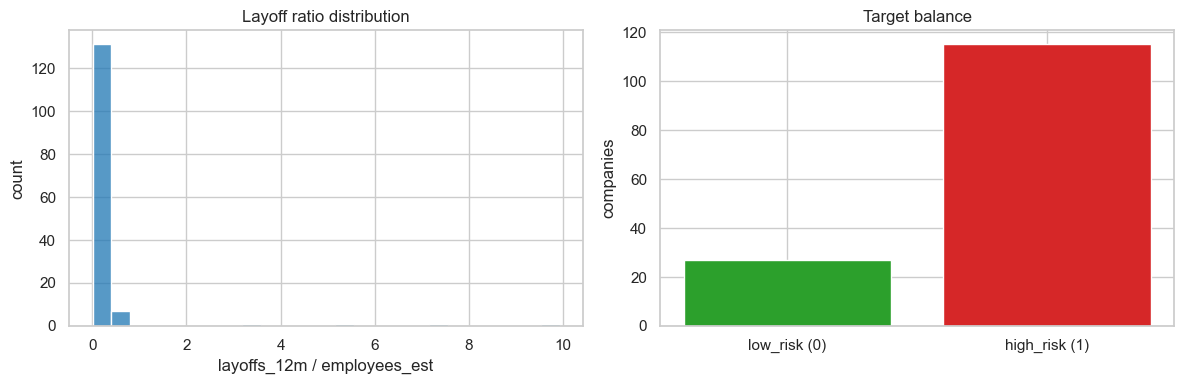

In [8]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(clean_df['layoff_ratio'], bins=25, ax=axes[0], color='#1f77b4')
axes[0].set_title('Layoff ratio distribution')
axes[0].set_xlabel('layoffs_12m / employees_est')
axes[0].set_ylabel('count')

axes[1].bar(['low_risk (0)', 'high_risk (1)'], class_counts.values, color=['#2ca02c', '#d62728'])
axes[1].set_title('Target balance')
axes[1].set_ylabel('companies')

plt.tight_layout()
plt.show()



### Visual: industries with highest high-risk share
Highlight industries where the model target is most frequently triggered.


C:\Users\Daniel\AppData\Local\Temp\ipykernel_21964\757997729.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_risk, y='industry', x=target_col, palette='mako')


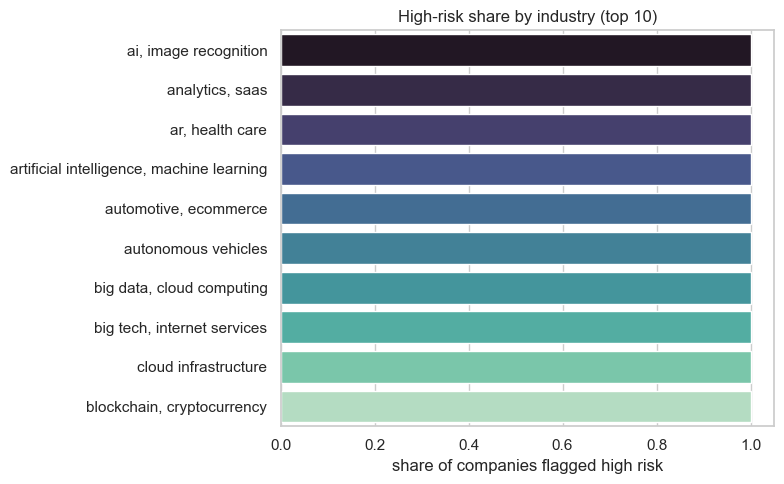

In [9]:

industry_risk = (
    clean_df.groupby('industry')[target_col]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
plt.figure(figsize=(8, 5))
sns.barplot(data=industry_risk, y='industry', x=target_col, palette='mako')
plt.title('High-risk share by industry (top 10)')
plt.xlabel('share of companies flagged high risk')
plt.ylabel('')
plt.tight_layout()
plt.show()



## Takeaways
- Raw CSV is sparse in `additional_notes` and some impact percentages; `reported_date` and headcount fields need parsing before use.
- Layoff activity peaks in specific months; the ETL notebook rolls these into 12-month and 90-day aggregates.
- High-risk class dominates (~80%), so `class_weight='balanced'` in `Modeling.ipynb` remains important.
- Continue with `Data/data_cleaning_script.ipynb` to regenerate `cleaned_dataset.csv`, then train models in `Notebooks/Modeling.ipynb` and predict via `Notebooks/Predict_Demo.ipynb`.
